In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
# disable deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 1. Data Loading
loan_df = pd.read_csv('loan.csv')
payment_df = pd.read_csv('payment.csv')
user_df = pd.read_csv('user.csv')

In [4]:
# 2. Feature Engineering

# Loan Amount Bins
loan_df['amount_bin'] = pd.qcut(loan_df['amount'], q=3, labels=['low', 'medium', 'high'])

# Payment Behavior
total_payment_per_loan = payment_df.groupby('loan_id')['amount'].sum()
loan_df['payment_difference'] = loan_df['id'].map(total_payment_per_loan) - loan_df['amount']

# Age Bins
user_df['birth_year'] = pd.to_datetime(user_df['birth_date']).dt.year
current_year = pd.Timestamp.now().year
user_df['age'] = current_year - user_df['birth_year']
bins = [0, 25, 40, 60, 100]
labels = ['young', 'young_adult', 'middle_aged', 'senior']
user_df['age_bin'] = pd.cut(user_df['age'], bins=bins, labels=labels, right=False)

# History of Overdue Loans
overdue_loans = loan_df[loan_df['status'] == 'overdue'].groupby('client_id').size()
user_df['num_overdue_loans'] = user_df['id'].map(overdue_loans).fillna(0)

In [5]:
# 3. Merging Data
merged_df = loan_df.merge(user_df, left_on='client_id', right_on='id', suffixes=('_loan', '_user'))

# Prepare final dataset
final_df = merged_df[merged_df['status'].isin(['paid', 'overdue'])][['amount', 'duration', 'amount_bin', 
                                                                     'payment_difference', 'age', 'age_bin', 
                                                                     'num_overdue_loans', 'status']]
final_df['status'] = final_df['status'].map({'paid': 1, 'overdue': 0})
final_df = pd.get_dummies(final_df, columns=['amount_bin', 'age_bin'], drop_first=True)

In [6]:
# 4. Data Splitting
X = final_df.drop('status', axis=1)
y = final_df['status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# 5. Model Training
model = xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False)
model.fit(X_train.fillna(0), y_train, eval_metric='logloss')
y_val_pred = model.predict(X_val.fillna(0))

/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

In [8]:
# Performance Metrics
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.998399241121717
F1 Score: 0.9989904655075714


In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 3481     1]
 [   26 13359]]


Text(0.5, 0, 'Predicted label')

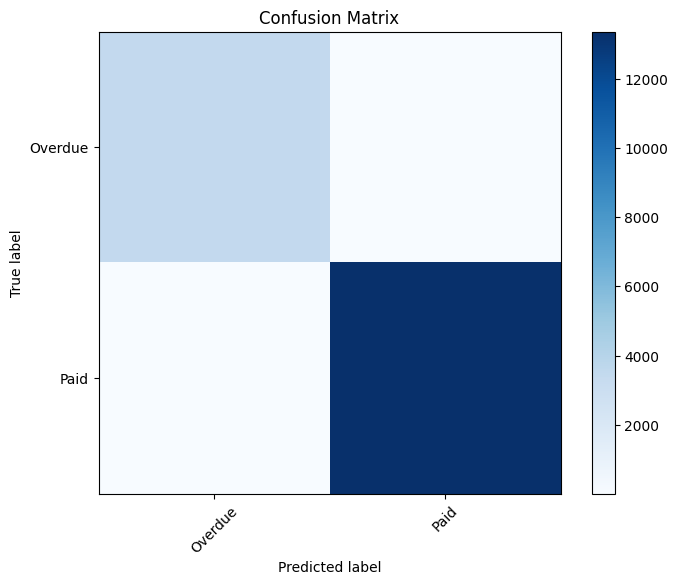

In [10]:
# Manually plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Overdue", "Paid"], rotation=45)
plt.yticks(tick_marks, ["Overdue", "Paid"])
plt.ylabel('True label')
plt.xlabel('Predicted label')


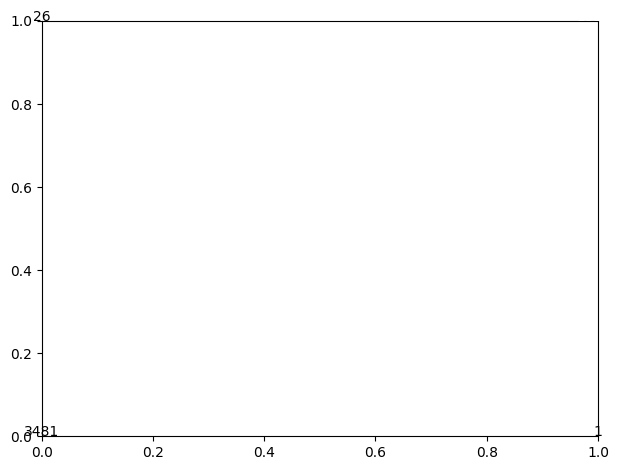

In [11]:
import itertools

# Displaying the values in the matrix
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(

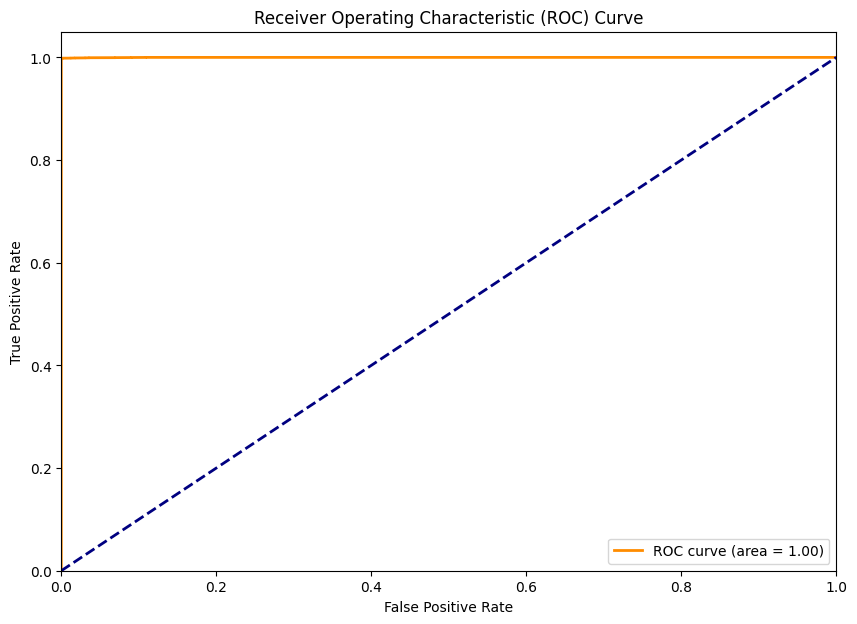

In [12]:
# 2. ROC Curve and AUC
y_val_prob = model.predict_proba(X_val.fillna(0))[:, 1]  # probabilities for the positive class
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

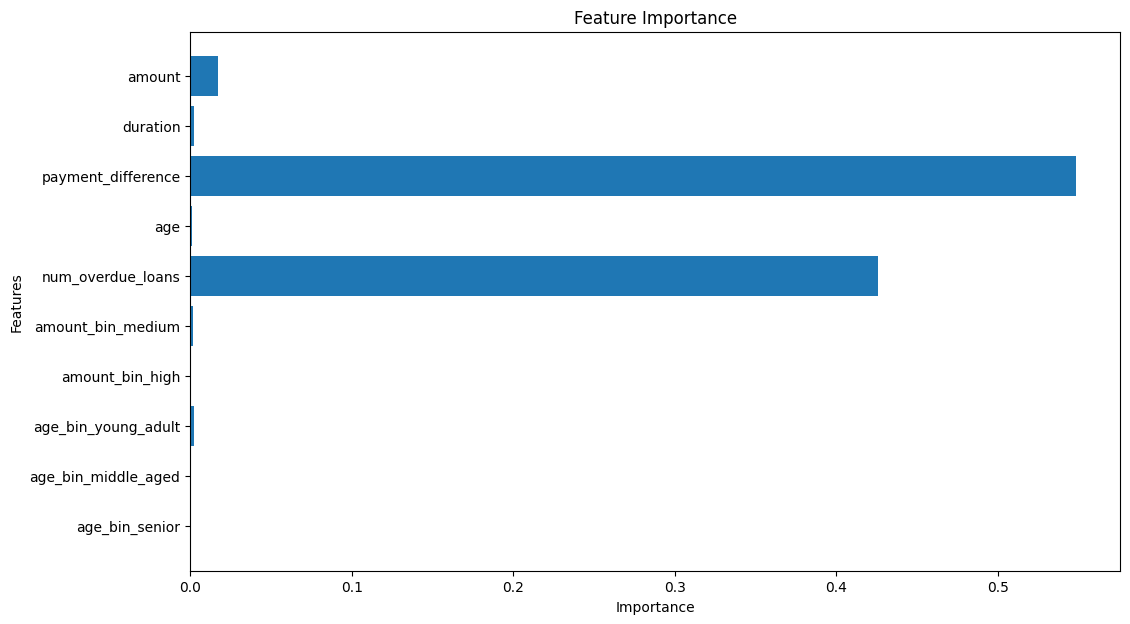

In [13]:
# 3. Feature Importance
feature_importance = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(12, 7))
plt.barh(features, feature_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [14]:
# 4. Potential Overfitting Check
y_train_pred = model.predict(X_train.fillna(0))
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {accuracy}")

Training Accuracy: 0.9988735233521574
Validation Accuracy: 0.998399241121717


/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(

In [15]:
model.save_model('model_v1.pkl')

/home/mart/git/creditstar-analysis/venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:57:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
